# Weather Exploratory Data Analysis

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.stats import shapiro
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

In [3]:
data = pd.read_csv("data\cleaned\data_all.csv")[["date", "state", "tavg", "tmin", "tmax", "prcp"]]

In [4]:
data["date"] = pd.to_datetime(data["date"])

In [5]:
data.head()

,date,state,tavg,tmin,tmax,prcp
0,2019-01-02,Delhi,13.8,6.5,23.0,0.0
1,2019-01-02,Karnataka,19.9,12.4,28.1,0.0
2,2019-01-02,Maharashtra,25.5,14.6,31.0,0.0
3,2019-01-02,Rajasthan,19.9,12.4,28.1,0.0
4,2019-01-02,Tamil Nadu,24.4,19.3,29.0,0.0


To reiterate, we have information about the daily precipitation, minimal, maximal, and average temperature in 6 major Indian states from 02 Jan 2019 and 01 Jan 2020. In this notebook I will perform exploratory data analysis and see what claims we can make about the data.

Firstly, we can visualize the data.

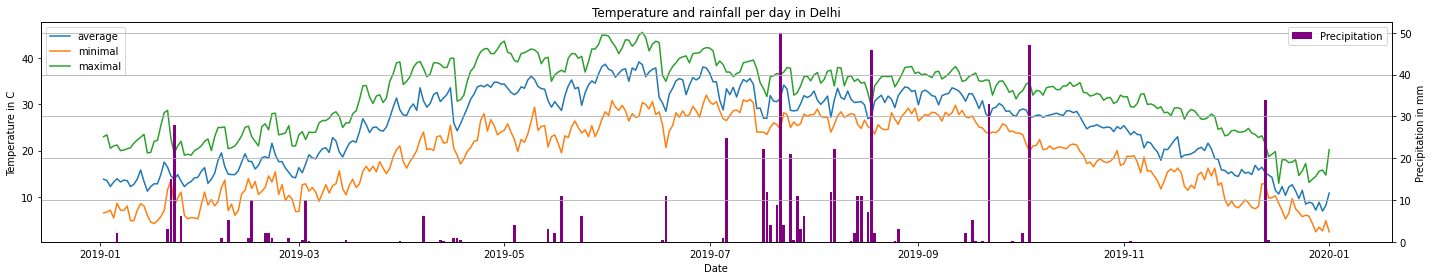

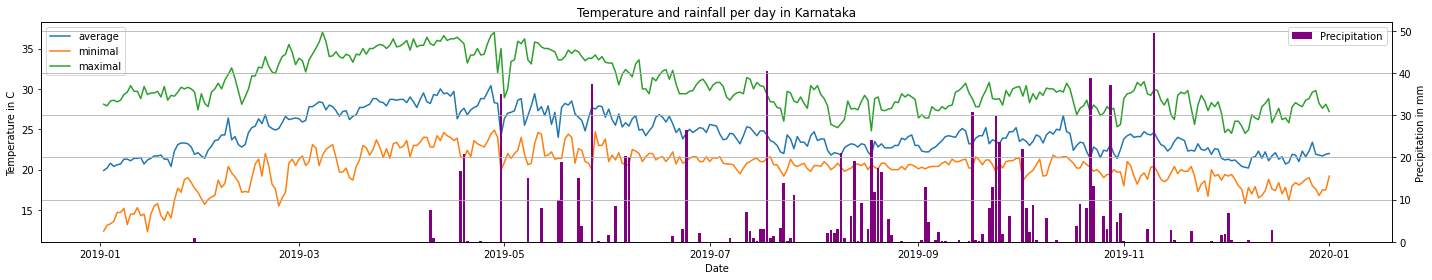

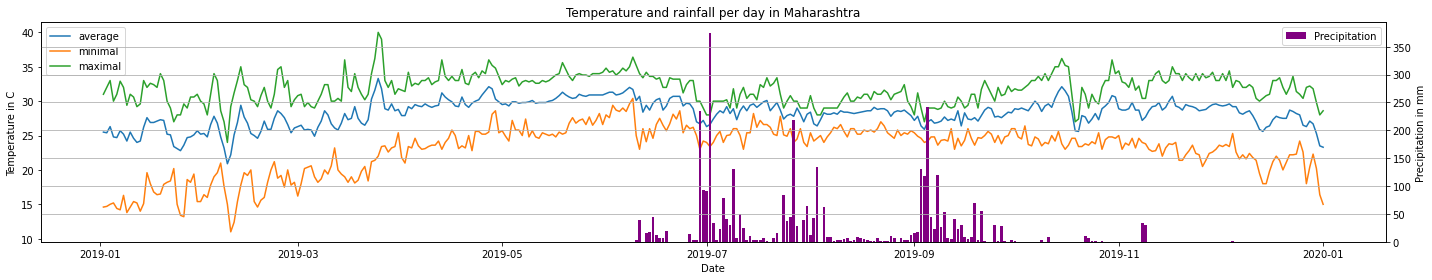

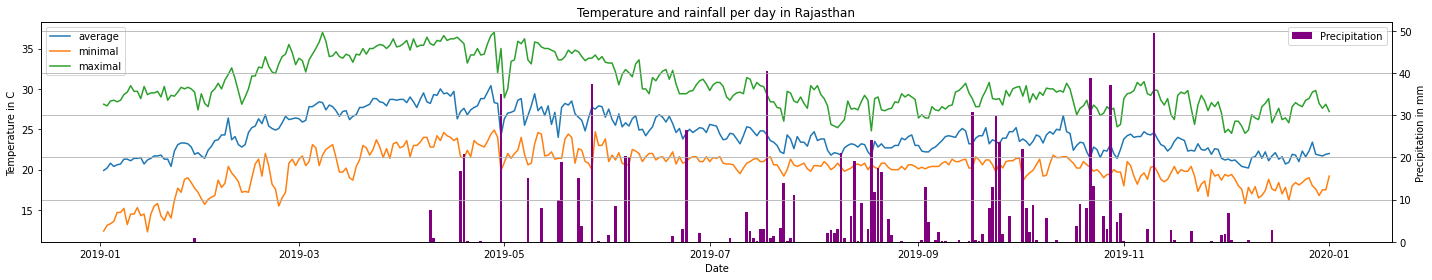

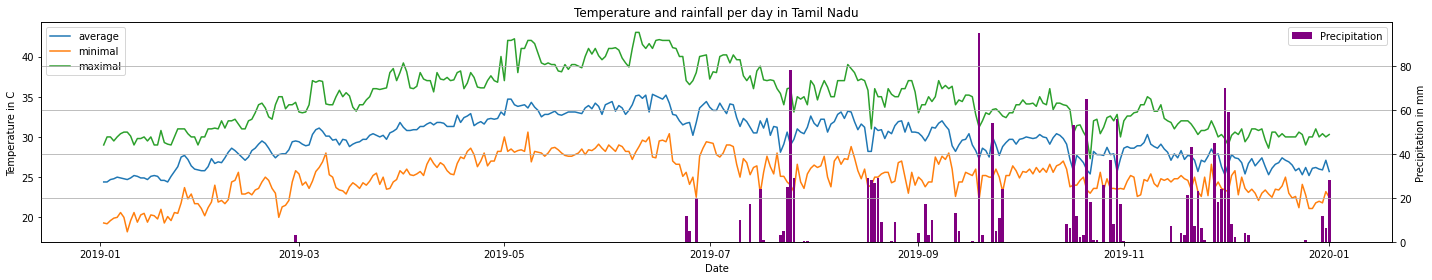

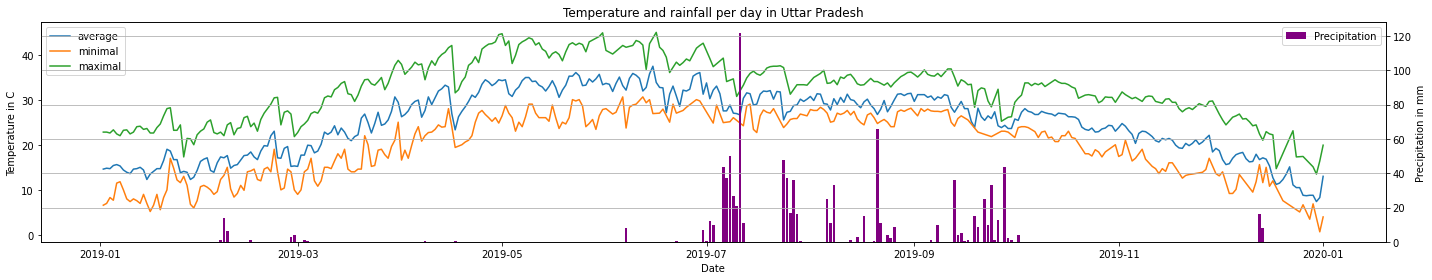

In [6]:
for name, group in data.groupby("state"):
    fig, ax1 = plt.subplots(figsize = (20, 4))    
    
    df = group.set_index("date")
    ax1.plot(df["tavg"], label = "average")
    ax1.plot(df["tmin"], label = "minimal")
    ax1.plot(df["tmax"], label = "maximal")
    #plt.bar(df.index, df["prcp"], label = "precipitation in mm")
    xticks = group[(group["date"].dt.day == 2) | (group["date"].dt.year == 2020)]["date"]
    ax1.set_xticks(xticks)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Temperature in C")
    
    ax2 = ax1.twinx()
    ax2.bar(df.index, df["prcp"], label = "Precipitation", color = "purple")
    ax2.set_ylabel("Precipitation in mm")
    
    plt.title("Temperature and rainfall per day in " + name)
    plt.tight_layout()
    plt.grid()
    ax1.legend(loc="upper left")
    ax2.legend()
    plt.show()

Immediately we can see that the temperatures contain noise, so I will smooth them in exactly the same way I smooth the power data in the power data analyis. Also, we can see that the rainfall is concentrated in the second half of the year for most states.

In [7]:
def smooth_temperatures(grouped_df):
    groups = [gr for name, gr in grouped_df]
    for df in groups:
        df.reset_index(drop = True, inplace = True)
        df["smooth_tavg"] = savgol_filter(df["tavg"], 15, 3)
        df["smooth_tmin"] = savgol_filter(df["tmin"], 15, 3)
        df["smooth_tmax"] = savgol_filter(df["tmax"], 15, 3)
    return pd.concat(groups).sort_values(by = ["date", "state"]).reset_index(drop = True)

In [8]:
data = smooth_temperatures(data.groupby("state"))

Here are the results of the smoothing:

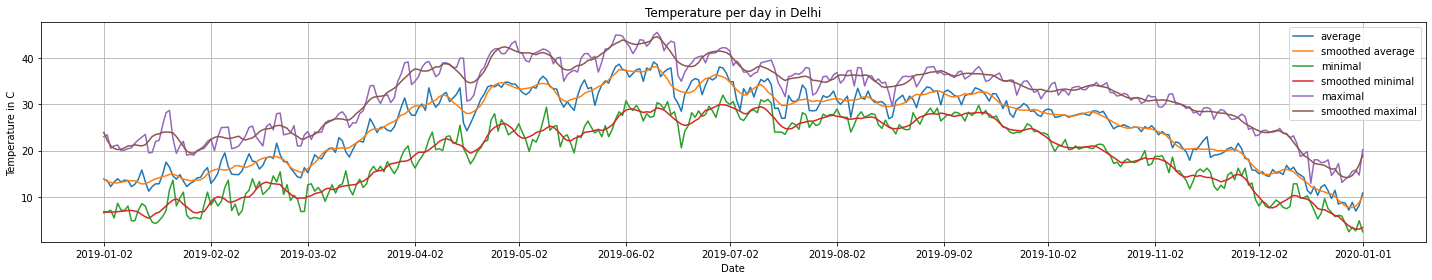

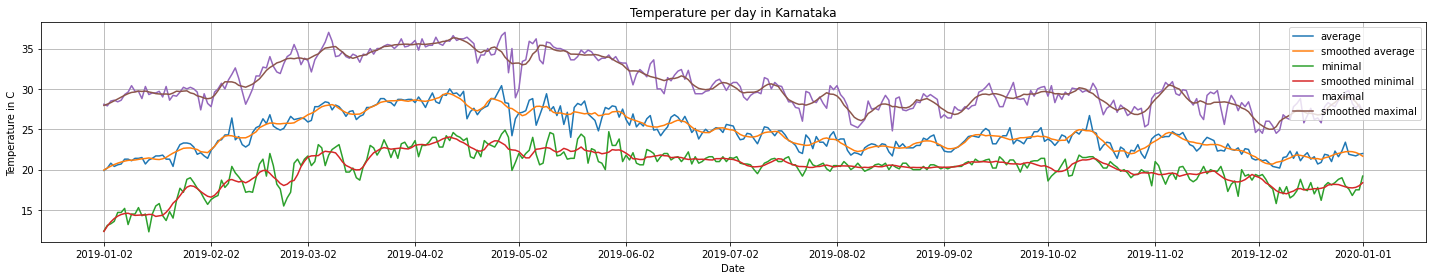

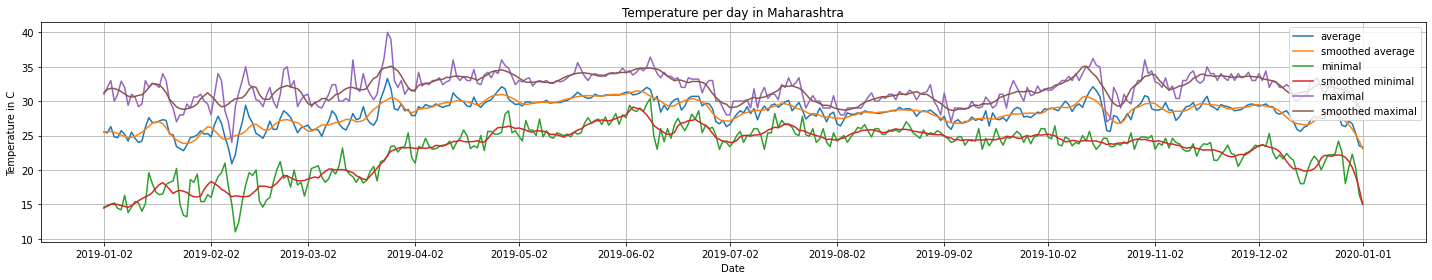

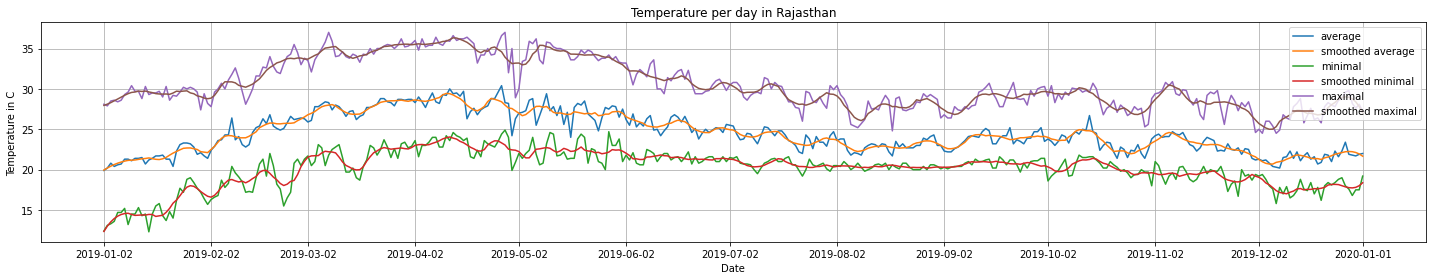

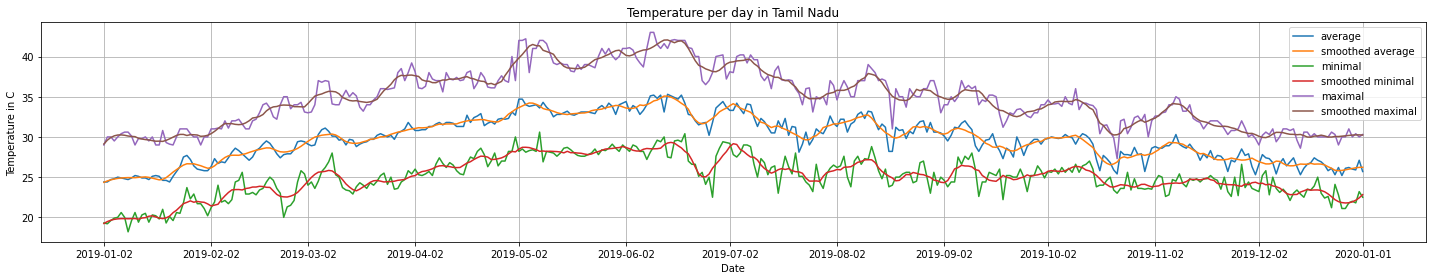

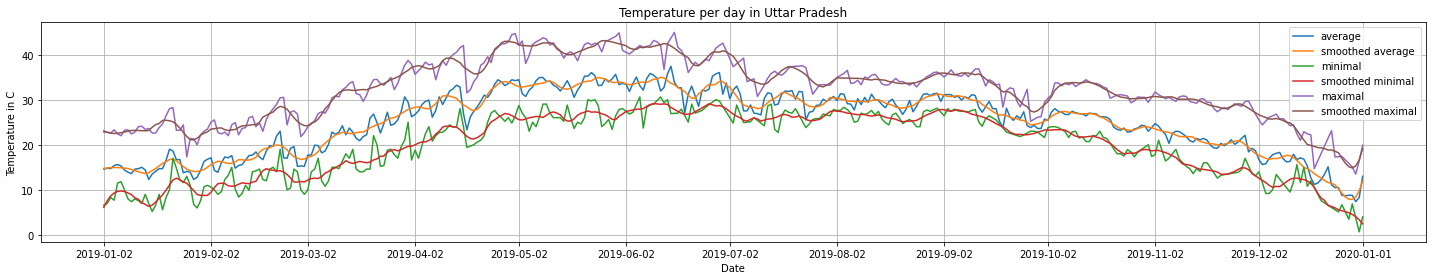

In [9]:
for name, group in data.groupby("state"):
    fig, ax1 = plt.subplots(figsize = (20, 4))    
    
    df = group.set_index("date")
    ax1.plot(df["tavg"], label = "average")
    ax1.plot(df["smooth_tavg"], label = "smoothed average")
    ax1.plot(df["tmin"], label = "minimal")
    ax1.plot(df["smooth_tmin"], label = "smoothed minimal")
    ax1.plot(df["tmax"], label = "maximal")
    ax1.plot(df["smooth_tmax"], label = "smoothed maximal")
    xticks = group[(group["date"].dt.day == 2) | (group["date"].dt.year == 2020)]["date"]
    ax1.set_xticks(xticks)
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Temperature in C")
    
    plt.title("Temperature per day in " + name)
    plt.tight_layout()
    plt.grid()
    ax1.legend(loc="upper right")
    plt.show()

It appears that the smoothed data resembles the tendencies of the original data but eliminates the noise, which would make it easier to work with later.

We can begin the EDA by testing the difference in temperatures between months for all states, analogically to the EDA for the power data. We first need to test the normality of the data.

In [10]:
def test_normality(df, gr_col, val_col):
    for name, group in df.groupby(gr_col):
        p = shapiro(group[val_col]).pvalue
        is_normal = ""
        if p < 0.05:
            is_normal = " NOT"
        print(str(name) + ": " + val_col + " is" + is_normal + " normally distributed")

In [11]:
test_normality(data, "state", "smooth_tavg")

Delhi: smooth_tavg is NOT normally distributed
Karnataka: smooth_tavg is NOT normally distributed
Maharashtra: smooth_tavg is NOT normally distributed
Rajasthan: smooth_tavg is NOT normally distributed
Tamil Nadu: smooth_tavg is NOT normally distributed
Uttar Pradesh: smooth_tavg is NOT normally distributed


In [12]:
test_normality(data, "state", "smooth_tmin")

Delhi: smooth_tmin is NOT normally distributed
Karnataka: smooth_tmin is NOT normally distributed
Maharashtra: smooth_tmin is NOT normally distributed
Rajasthan: smooth_tmin is NOT normally distributed
Tamil Nadu: smooth_tmin is NOT normally distributed
Uttar Pradesh: smooth_tmin is NOT normally distributed


In [13]:
test_normality(data, "state", "smooth_tmax")

Delhi: smooth_tmax is NOT normally distributed
Karnataka: smooth_tmax is NOT normally distributed
Maharashtra: smooth_tmax is NOT normally distributed
Rajasthan: smooth_tmax is NOT normally distributed
Tamil Nadu: smooth_tmax is NOT normally distributed
Uttar Pradesh: smooth_tmax is NOT normally distributed


It appears that all measures for temperature are not normally distributed for all states. Therefore, we again must settle for non-parametric tests.

In [14]:
data["month"] = data["date"].dt.month

To test the difference in temperature for all months, I perform a Kruskal-Wallis test.

In [15]:
def test_temperature_between_months(grouped_df, val_col):
    for state, group in grouped_df:
        result = kruskal(group[group["date"].dt.month == 1][val_col],
                        group[group["date"].dt.month == 2][val_col],
                        group[group["date"].dt.month == 3][val_col],
                        group[group["date"].dt.month == 4][val_col],
                        group[group["date"].dt.month == 5][val_col],
                        group[group["date"].dt.month == 6][val_col],
                        group[group["date"].dt.month == 7][val_col],
                        group[group["date"].dt.month == 8][val_col],
                        group[group["date"].dt.month == 9][val_col],
                        group[group["date"].dt.month == 10][val_col],
                        group[group["date"].dt.month == 11][val_col],
                        group[group["date"].dt.month == 12][val_col])
        conclusion = "NO"
        if result.pvalue < 0.05:
            conclusion = ""
        print(state)
        print("There is" + conclusion + " significant difference in " + val_col + " between months")

In [16]:
test_temperature_between_months(data.groupby("state"), "smooth_tavg")
print()
test_temperature_between_months(data.groupby("state"), "smooth_tmin")
print()
test_temperature_between_months(data.groupby("state"), "smooth_tmax")

Delhi
There is significant difference in smooth_tavg between months
Karnataka
There is significant difference in smooth_tavg between months
Maharashtra
There is significant difference in smooth_tavg between months
Rajasthan
There is significant difference in smooth_tavg between months
Tamil Nadu
There is significant difference in smooth_tavg between months
Uttar Pradesh
There is significant difference in smooth_tavg between months

Delhi
There is significant difference in smooth_tmin between months
Karnataka
There is significant difference in smooth_tmin between months
Maharashtra
There is significant difference in smooth_tmin between months
Rajasthan
There is significant difference in smooth_tmin between months
Tamil Nadu
There is significant difference in smooth_tmin between months
Uttar Pradesh
There is significant difference in smooth_tmin between months

Delhi
There is significant difference in smooth_tmax between months
Karnataka
There is significant difference in smooth_tmax bet

The results from the test are significant for all temperature measurements across all states. Therefore, we can reject the null hypotheses and conclude that the median temperatures of at least 1 month is different from the rest. Again, we perform a Dunn's test to see how many pairs of medians are different

In [17]:
comparisons_tavg = [(name + " tavg", posthoc_dunn(df, val_col = "smooth_tavg", group_col = "month").round(3)) for name, df in data.groupby("state")]
comparisons_tmin = [(name + " tmin", posthoc_dunn(df, val_col = "smooth_tmin", group_col = "month").round(3)) for name, df in data.groupby("state")]
comparisons_tmax = [(name + " tmax", posthoc_dunn(df, val_col = "smooth_tmax", group_col = "month").round(3)) for name, df in data.groupby("state")]

In [18]:
comparisons_tavg[0][0]

'Delhi tavg'

In [19]:
comparisons_tavg[0][1]

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000,0.098,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.983
2,0.098,1.000,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.181,0.094
3,0.000,0.071,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.184,0.641,0.000
4,0.000,0.000,0.000,1.000,0.029,0.001,0.464,0.985,0.904,0.002,0.000,0.000
5,0.000,0.000,0.000,0.029,1.000,0.201,0.145,0.029,0.021,0.000,0.000,0.000
6,0.000,0.000,0.000,0.001,0.201,1.000,0.006,0.001,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.464,0.145,0.006,1.000,0.472,0.393,0.000,0.000,0.000
8,0.000,0.000,0.000,0.985,0.029,0.001,0.472,1.000,0.888,0.002,0.000,0.000
9,0.000,0.000,0.000,0.904,0.021,0.000,0.393,0.888,1.000,0.003,0.000,0.000
10,0.000,0.002,0.184,0.002,0.000,0.000,0.000,0.002,0.003,1.000,0.075,0.000


In [20]:
def count_significant_pairs(post_hoc_results):
    for i in range(len(post_hoc_results)):
        count = 0
        for col in post_hoc_results[i][1].columns:
            count += sum(post_hoc_results[i][1][col] < 0.05)
        print(post_hoc_results[i][0] + ": " + str(count/2) + " out of 61")

In [21]:
count_significant_pairs(comparisons_tavg)

Delhi tavg: 50.0 out of 61
Karnataka tavg: 49.0 out of 61
Maharashtra tavg: 50.0 out of 61
Rajasthan tavg: 49.0 out of 61
Tamil Nadu tavg: 56.0 out of 61
Uttar Pradesh tavg: 51.0 out of 61


In [22]:
count_significant_pairs(comparisons_tmin)

Delhi tmin: 51.0 out of 61
Karnataka tmin: 52.0 out of 61
Maharashtra tmin: 52.0 out of 61
Rajasthan tmin: 52.0 out of 61
Tamil Nadu tmin: 50.0 out of 61
Uttar Pradesh tmin: 52.0 out of 61


In [23]:
count_significant_pairs(comparisons_tmax)

Delhi tmax: 54.0 out of 61
Karnataka tmax: 48.0 out of 61
Maharashtra tmax: 46.0 out of 61
Rajasthan tmax: 48.0 out of 61
Tamil Nadu tmax: 54.0 out of 61
Uttar Pradesh tmax: 52.0 out of 61


As it can be seen from the results of the post hoc tests, most month pairs have significantly different median temperatures in all states. We can plot the medians to observe their behavior.

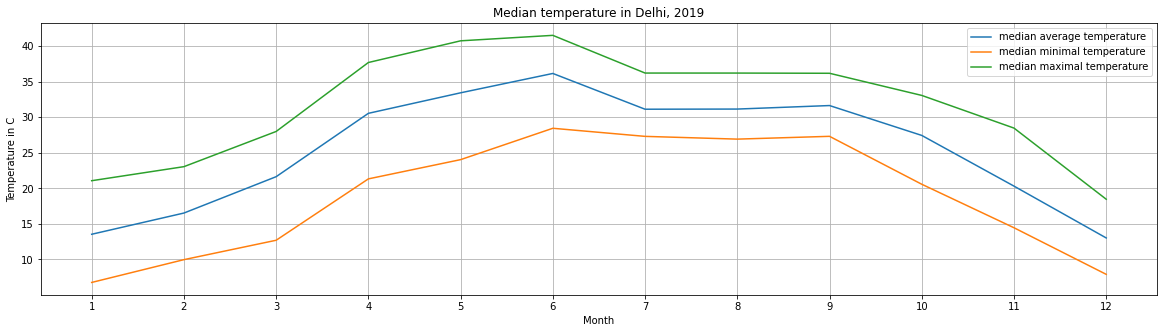

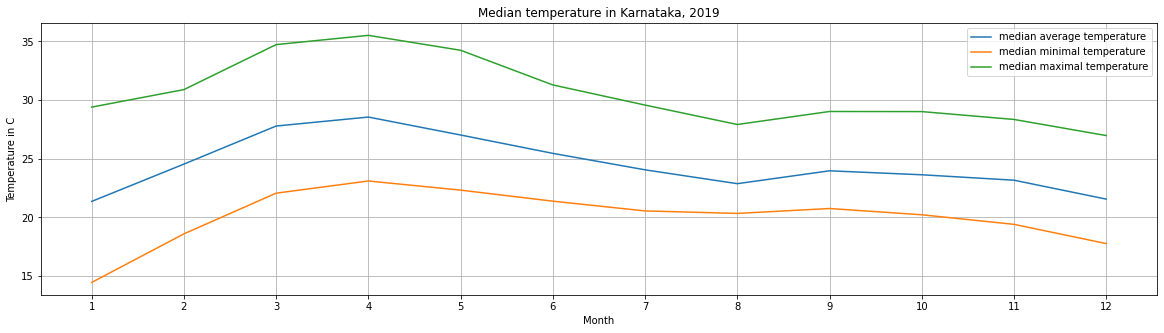

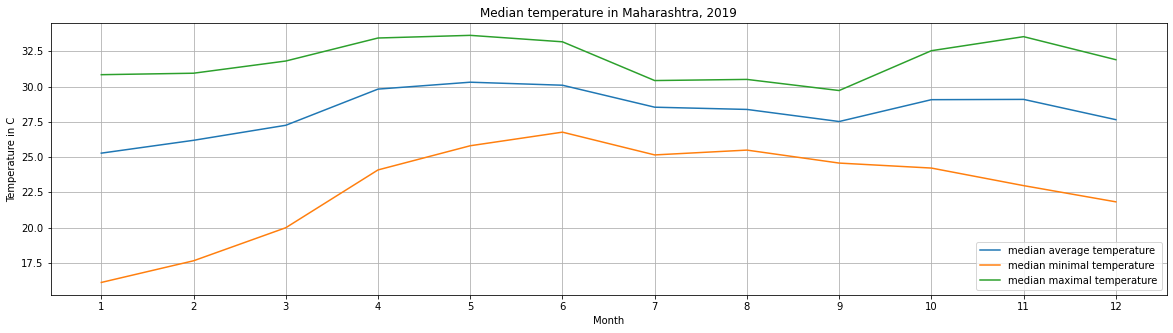

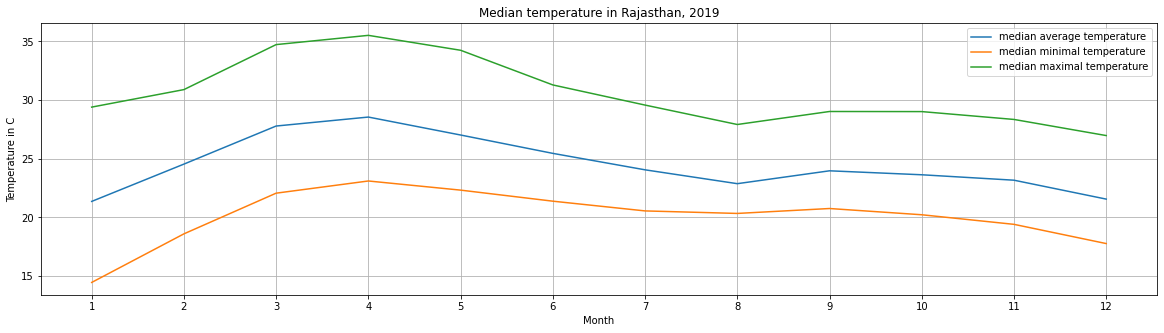

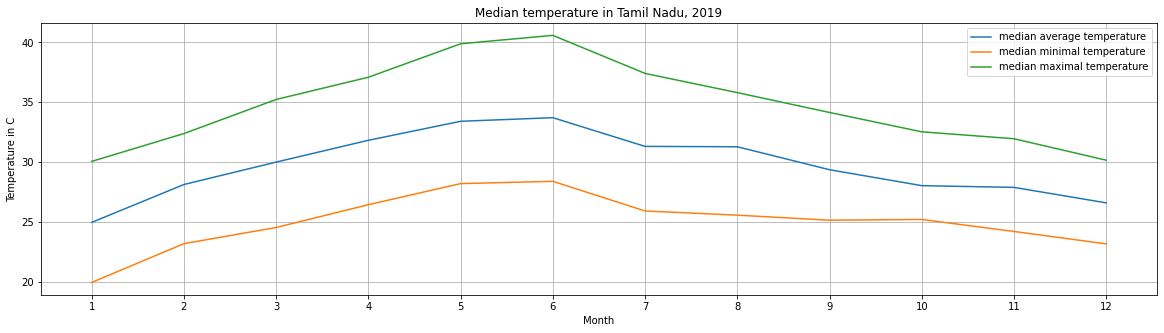

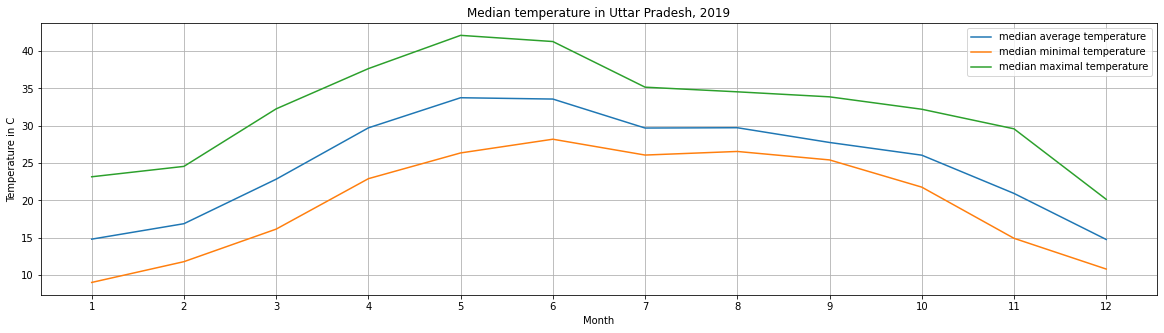

In [24]:
for name, group in data.groupby("state"):
    plt.figure(figsize = (20,5))
    grouped = group.groupby("month")
    plt.plot(grouped["smooth_tavg"].median(), label = "median average temperature")
    plt.plot(grouped["smooth_tmin"].median(), label = "median minimal temperature")
    plt.plot(grouped["smooth_tmax"].median(), label = "median maximal temperature")
    
    plt.title("Median temperature in " + name + ", 2019")
    plt.xlabel("Month")
    plt.ylabel("Temperature in C")
    plt.xticks(range(1,13))
    plt.legend()
    plt.grid()
    plt.show()

The temperature medians look like a rough concave down parabola. That is expected since the middle of the graph contains the summer months and the edges contain the winter months. There appear to be some assymetric drops in temperature in the 7 through 9 in all states. We can perhaps explain that with higher levels of rainfall in those periods as it was seen in the first graph. To further illustrate this effect I plot the median temperatures and sum of rainfall for each month.

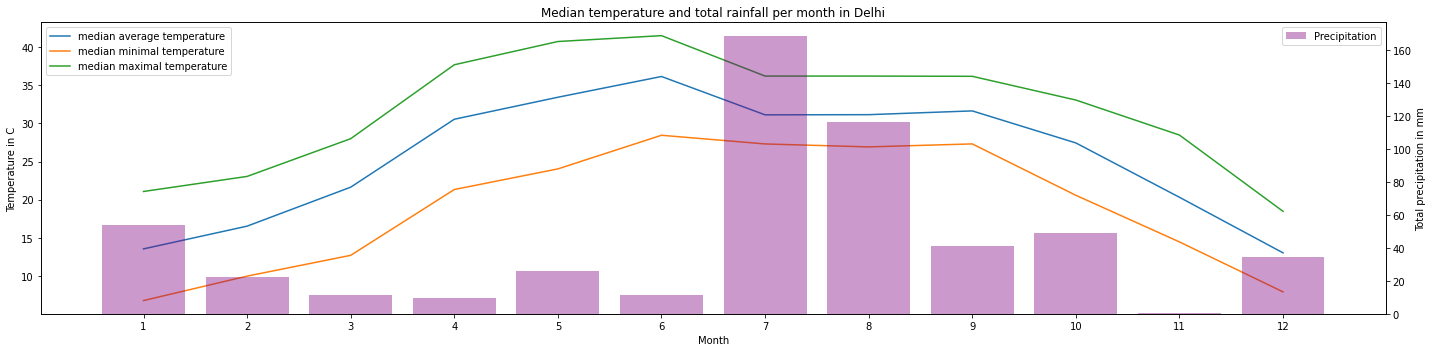

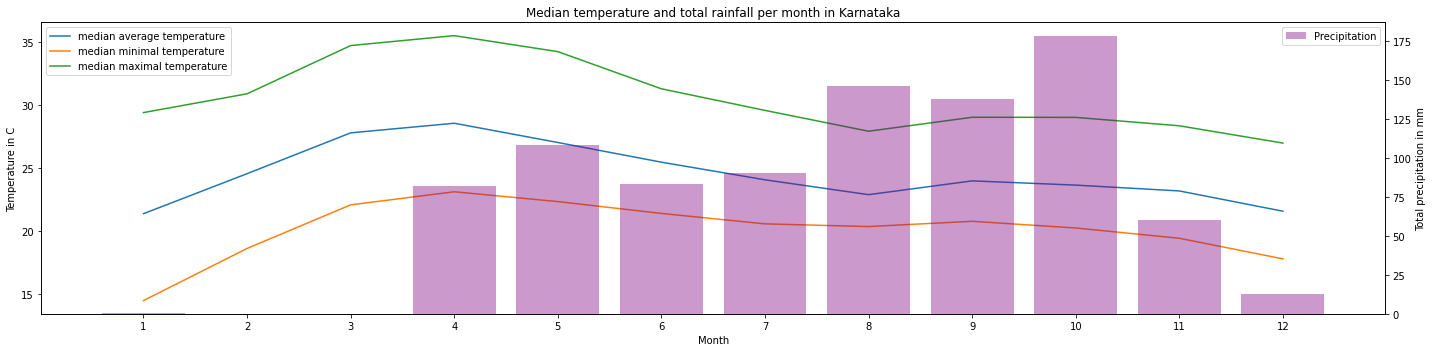

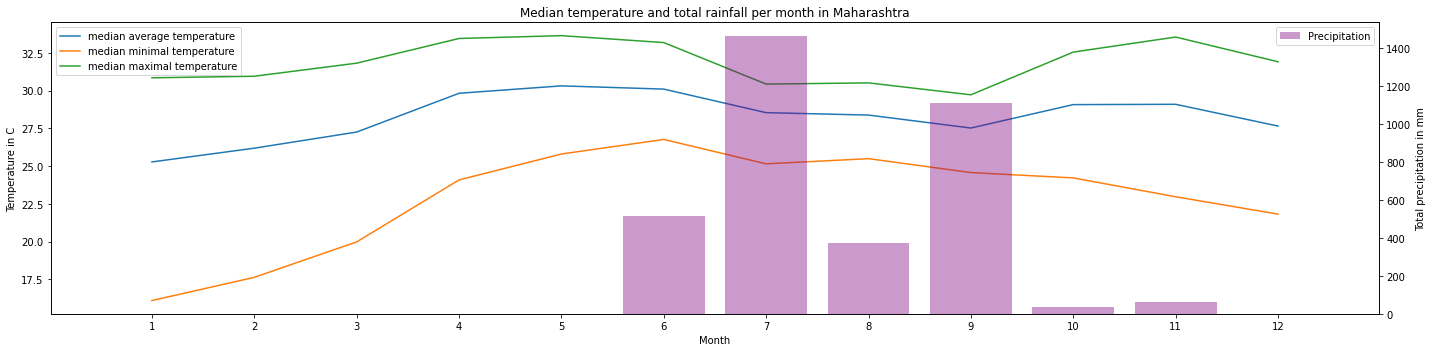

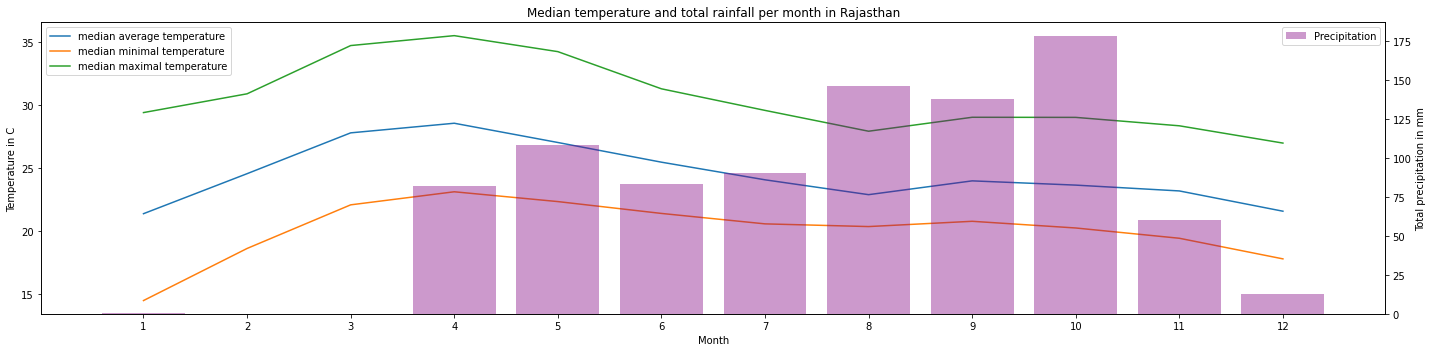

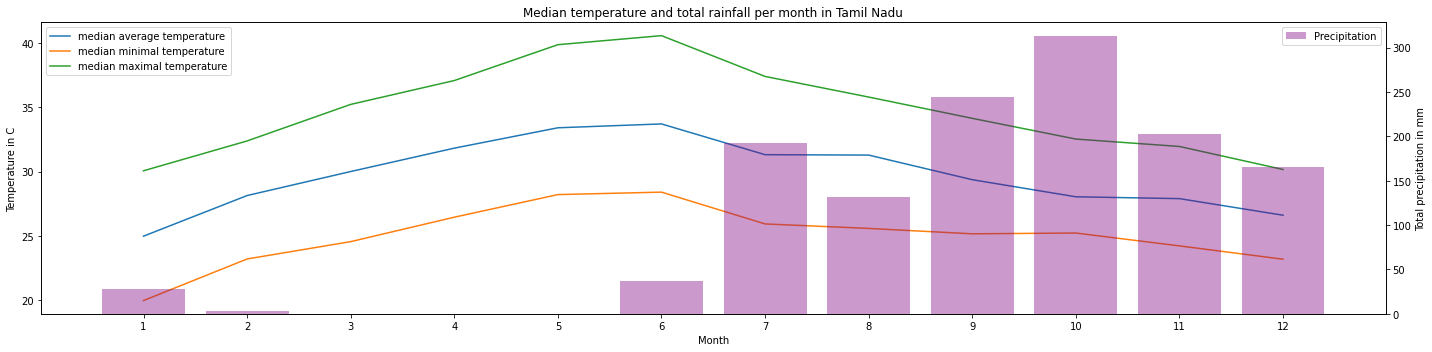

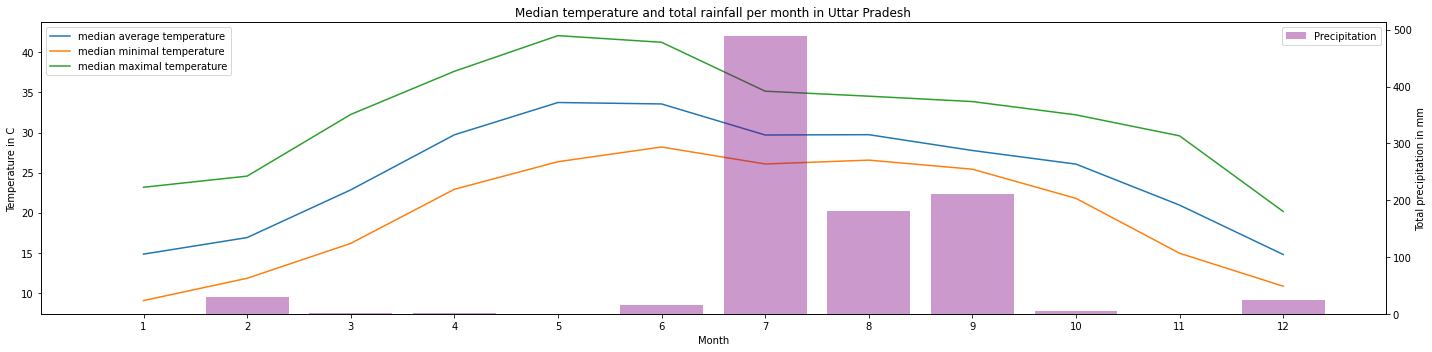

In [25]:
for name, group in data.groupby("state"):
    fig, ax1 = plt.subplots(figsize = (20, 5))    
    grouped = group.groupby("month")
    ax1.plot(grouped["smooth_tavg"].median(), label = "median average temperature")
    ax1.plot(grouped["smooth_tmin"].median(), label = "median minimal temperature")
    ax1.plot(grouped["smooth_tmax"].median(), label = "median maximal temperature")
    #plt.bar(df.index, df["prcp"], label = "precipitation in mm")
    xticks = range(1,13)
    ax1.set_xticks(xticks)
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Temperature in C")
    
    ax2 = ax1.twinx()
    sum_prcp = grouped["prcp"].sum()
    ax2.bar(sum_prcp.index, sum_prcp, label = "Precipitation", color = "purple", alpha = 0.4)
    ax2.set_ylabel("Total precipitation in mm")
    
    plt.title("Median temperature and total rainfall per month in " + name)
    plt.tight_layout()
    ax1.legend(loc="upper left")
    ax2.legend()
    plt.show()

We can observe the correlation between high precipitation and drops in the temperature. That can be expected since rainfall cools down the Earth.

That concludes the EDA of the weather data. To sum up, we found that temperature is significantly different for most months and high levels of rainfall cause drops in the temperature.